In [2]:
from setup_libs import *

In [3]:
import torch

## 7.3 Двуслойная (многослойная) нейронная сеть

#### Обозначения

Ключевая картинка на которой мы разбер процесс обучения нейронной сети.

Пусть у нас есть входной слой куда отправляется наш исходный вектор объекта. И есть 2 слоя один скрытый (внутренний $H$) и выходной ($M$).

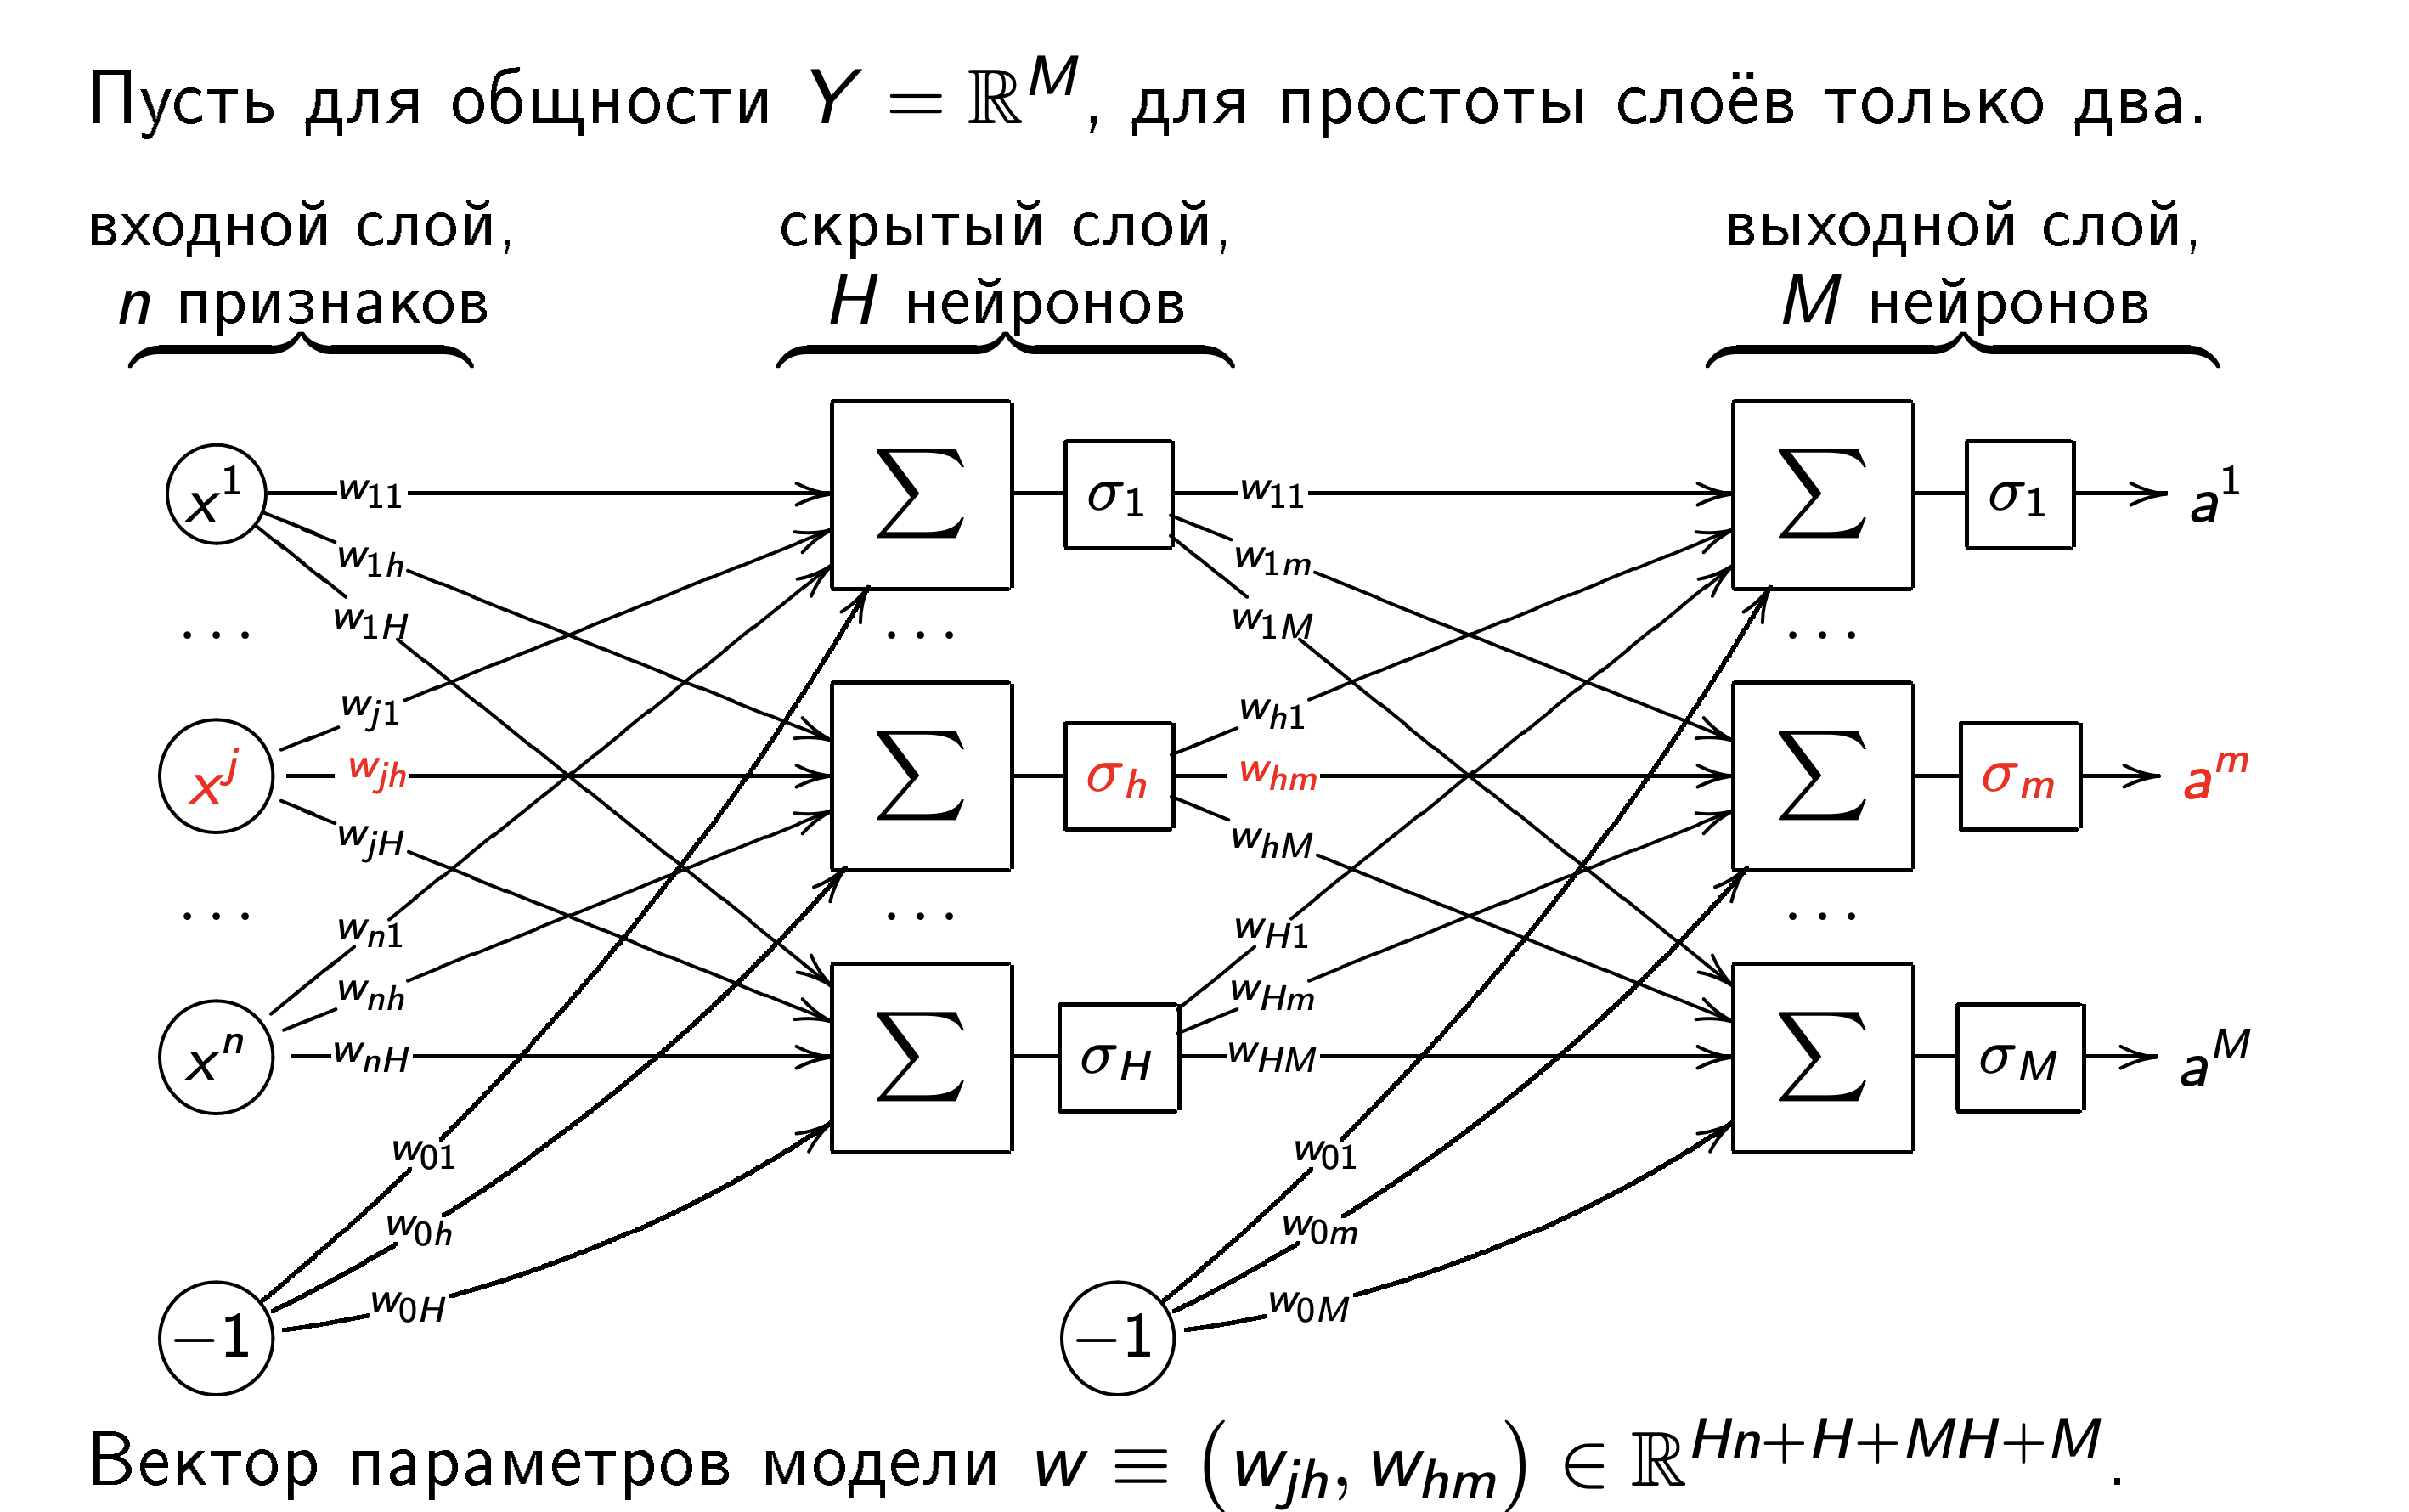

In [4]:
Image('images/1.png', width = 600)

Обозначения
* $x_i$ - вектор i-го объекта
* $x^j_i$ - j-ый элемент, i-го вектора (скаляр)

Без ограничений общности, будем считать, что в сеть подается вектор $x$ - без индексов. $x^j$ - $j$-ый элемент данного вектора

* $y$ - вектор ответа
* $y^{j}$ - элемент вектора объекта

Да, в отличие от стандартных наших алгоритмов, здесь удобнее считать, что мы возвращаем вектор, а не одно число.

* $a$ - вектор из выходного слоя нейронной сети
* $a^m$ - $m$-ый элемент выходного слоя нейронов
* $u$ - вектор из скрытого слоя нейронной сети
* $u^h$ - $h$-ый элемент выходного слоя нейронов

* $w_{hm}$ - веса слоя нейронной сети
В каждом слое свои веса: $w_{11}$ в скрытом и выходном слое - это **разные** параметры!

#### Обучение

На выходе вектор $a$ проверяется на некотором лоссе $\mathcal{L}$. Пусть это будет MSE.

$$\mathcal{L}(a,x,y) = \frac{1}{2}\sum_{m=1}^{M}(a^{m}(x) - y^{m})^2$$



Мы собираемся искать параметры **градиентным спуском**. $w_{hm}^{new} = w_{hm}^{old} - \eta \frac{\partial\mathcal{L}}{\partial w_{hm}}$

Значит нам необходимо найти $\frac{\partial\mathcal{L}}{\partial w_{hm}}$ для всех весов в каждом слое

Основная проблема: если мы будем пересчитывать этот градиент каждый раз независимо от других, то мы очень сильно пролетим по ассимптотике.

### Back-propagation

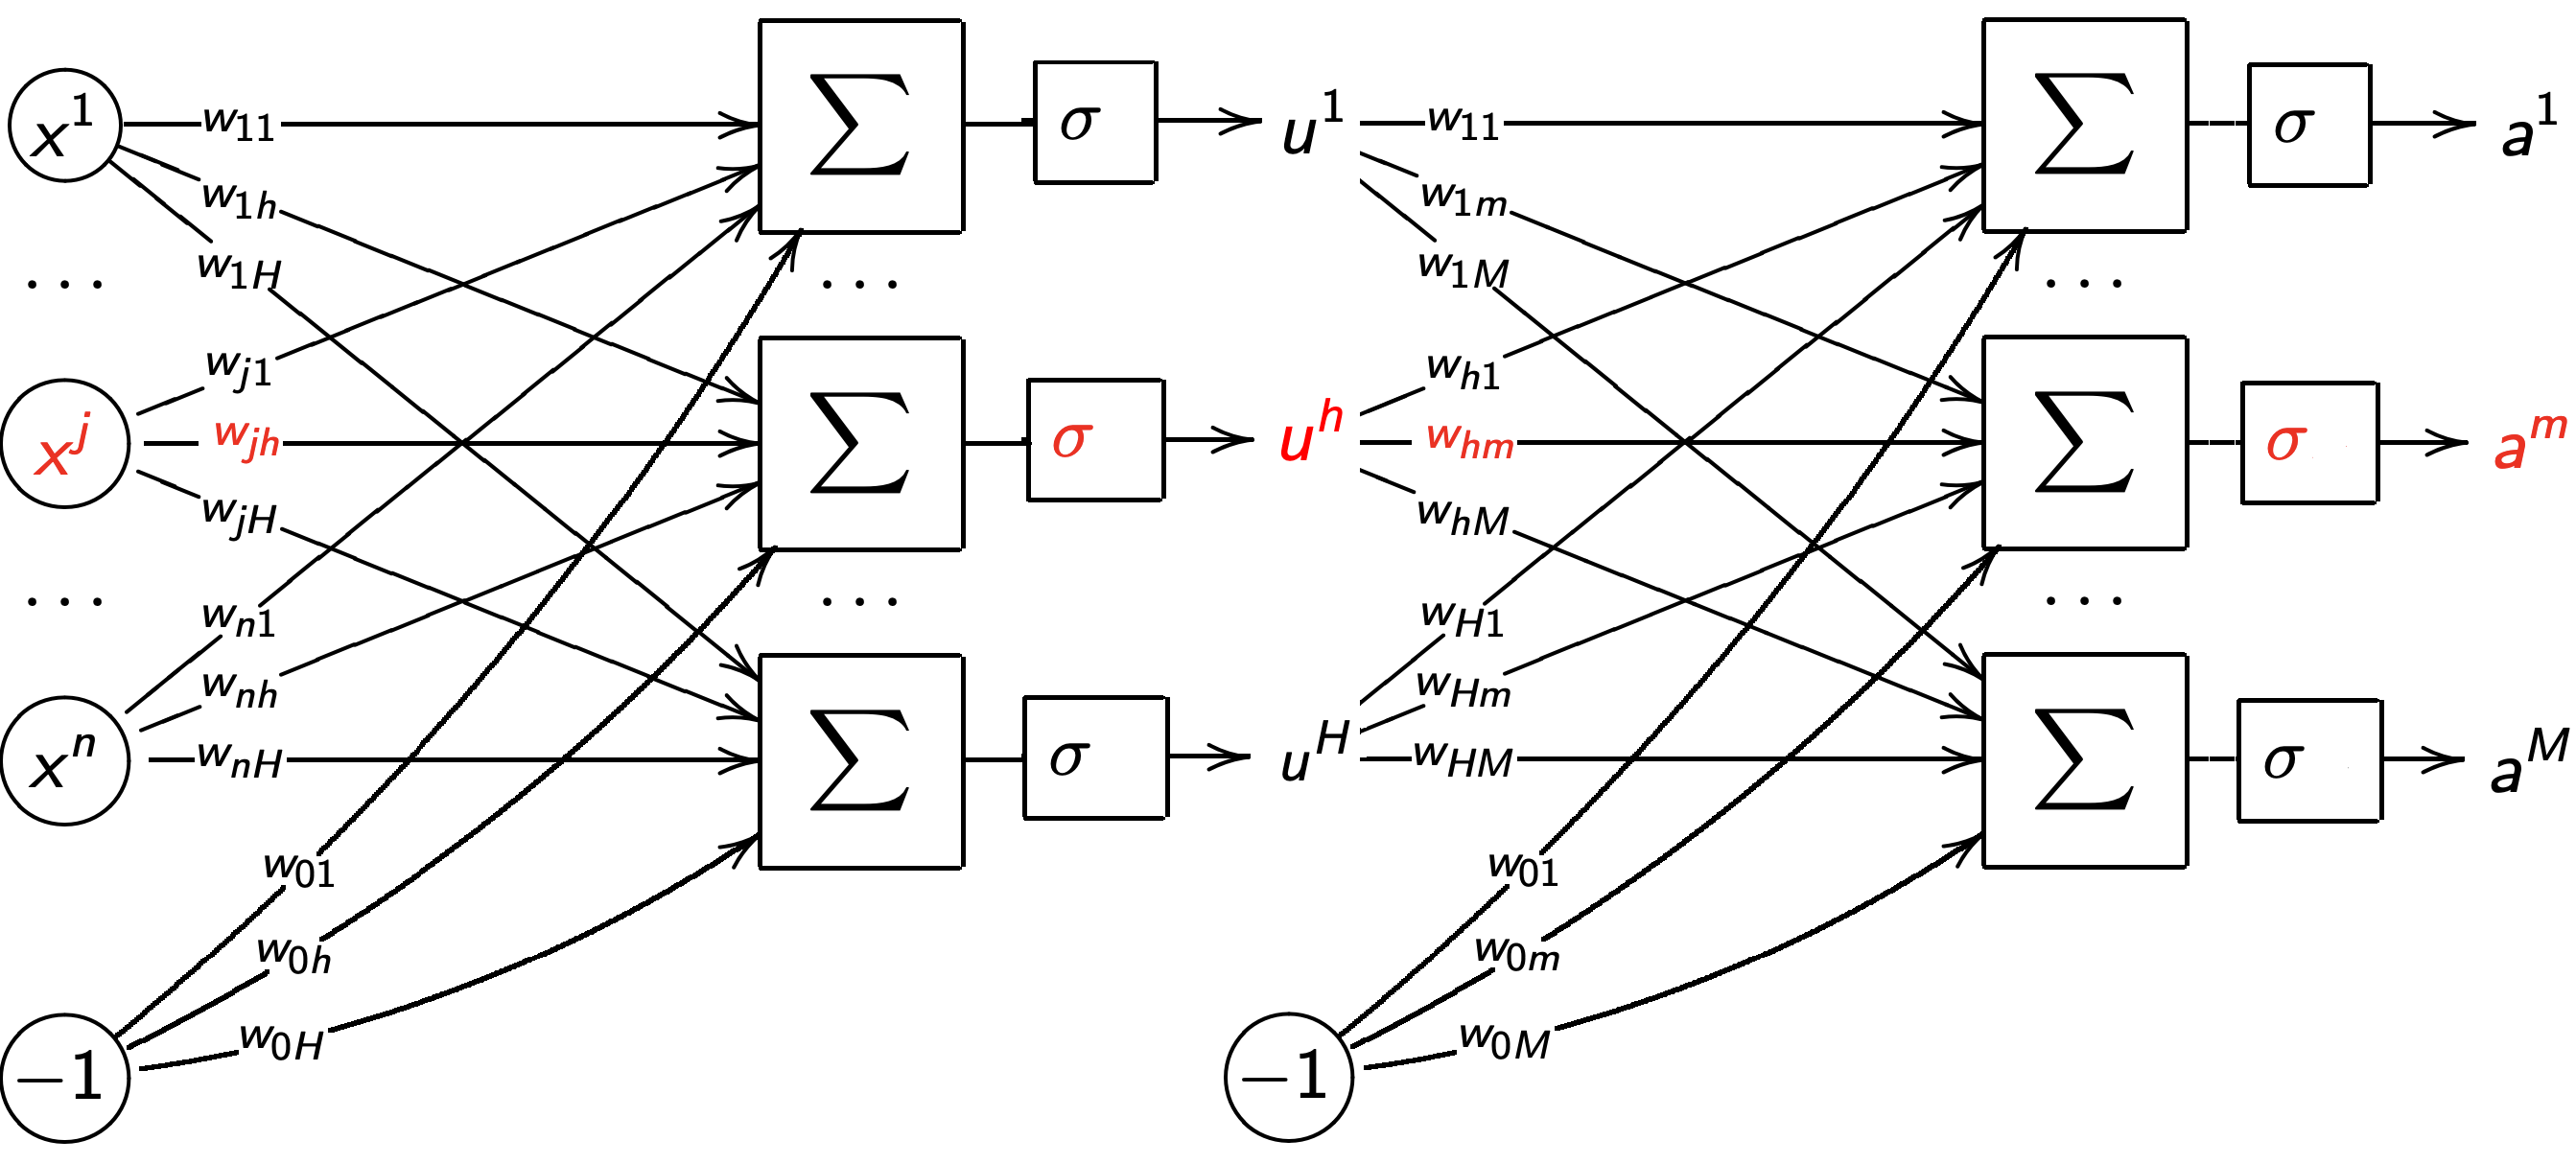

In [6]:
Image('images/nn.png', width = 600)

#### Forward шаг
Пусть мы сделали проход (inference) по нашей двухслойной сети вектором $x$ и нашли вектор $a$ (выходов).

Пока мы проводили эту операцию предпосчитали (индексы соответствуют картинке):
* вектора выхода из скрыторго слоя: 
$$u^h(x) = u^h = \sigma\Big(\sum_{j=0}^{n}w_{jh}x^j\Big)$$ 
* вектора выхода из выходного слоя: 
$$a^m(x) = a^{m} = \sigma\Big(\sum_{h=0}^{H}w_{hm}u^h(x)\Big)$$

Функции активации $\sigma$ считаем везде одинаковыми

#### Backward-шаг

Надо найти градиенты весов. Для удобства найдем вспомогательные градиенты $\frac{\partial\mathcal{L}}{\partial a^{m}}$ и $\frac{\partial\mathcal{L}}{\partial u^{h}}$  

* $$\frac{\partial\mathcal{L}}{\partial a^{m}} = \frac{\partial\frac{1}{2}\sum_{m=1}^{M}(a^{m} - y^{m})^2}{\partial a^{m}} = a^{m} - y^{m} = \varepsilon_a^{m}$$

* $$\frac{\partial\mathcal{L}}{\partial u^{h}} = \sum_{m=0}^{M}\frac{\partial\mathcal{L}}{\partial a^{m}}\frac{\partial a^{m}}{\partial u^{h}} = \sum_{m=0}^{M} \varepsilon_a^m \sigma^{'}(\star)w_{hm} = \varepsilon_{u}^{h}$$ где $\star = \sum_{h=0}^{H}w_{hm}u^h$ (эту штуку можно закешировать на этапе forward)

Backward шаг заключается в том, что мы "пускаем обратно" сеть для подсчета ошибок на каждом слое.

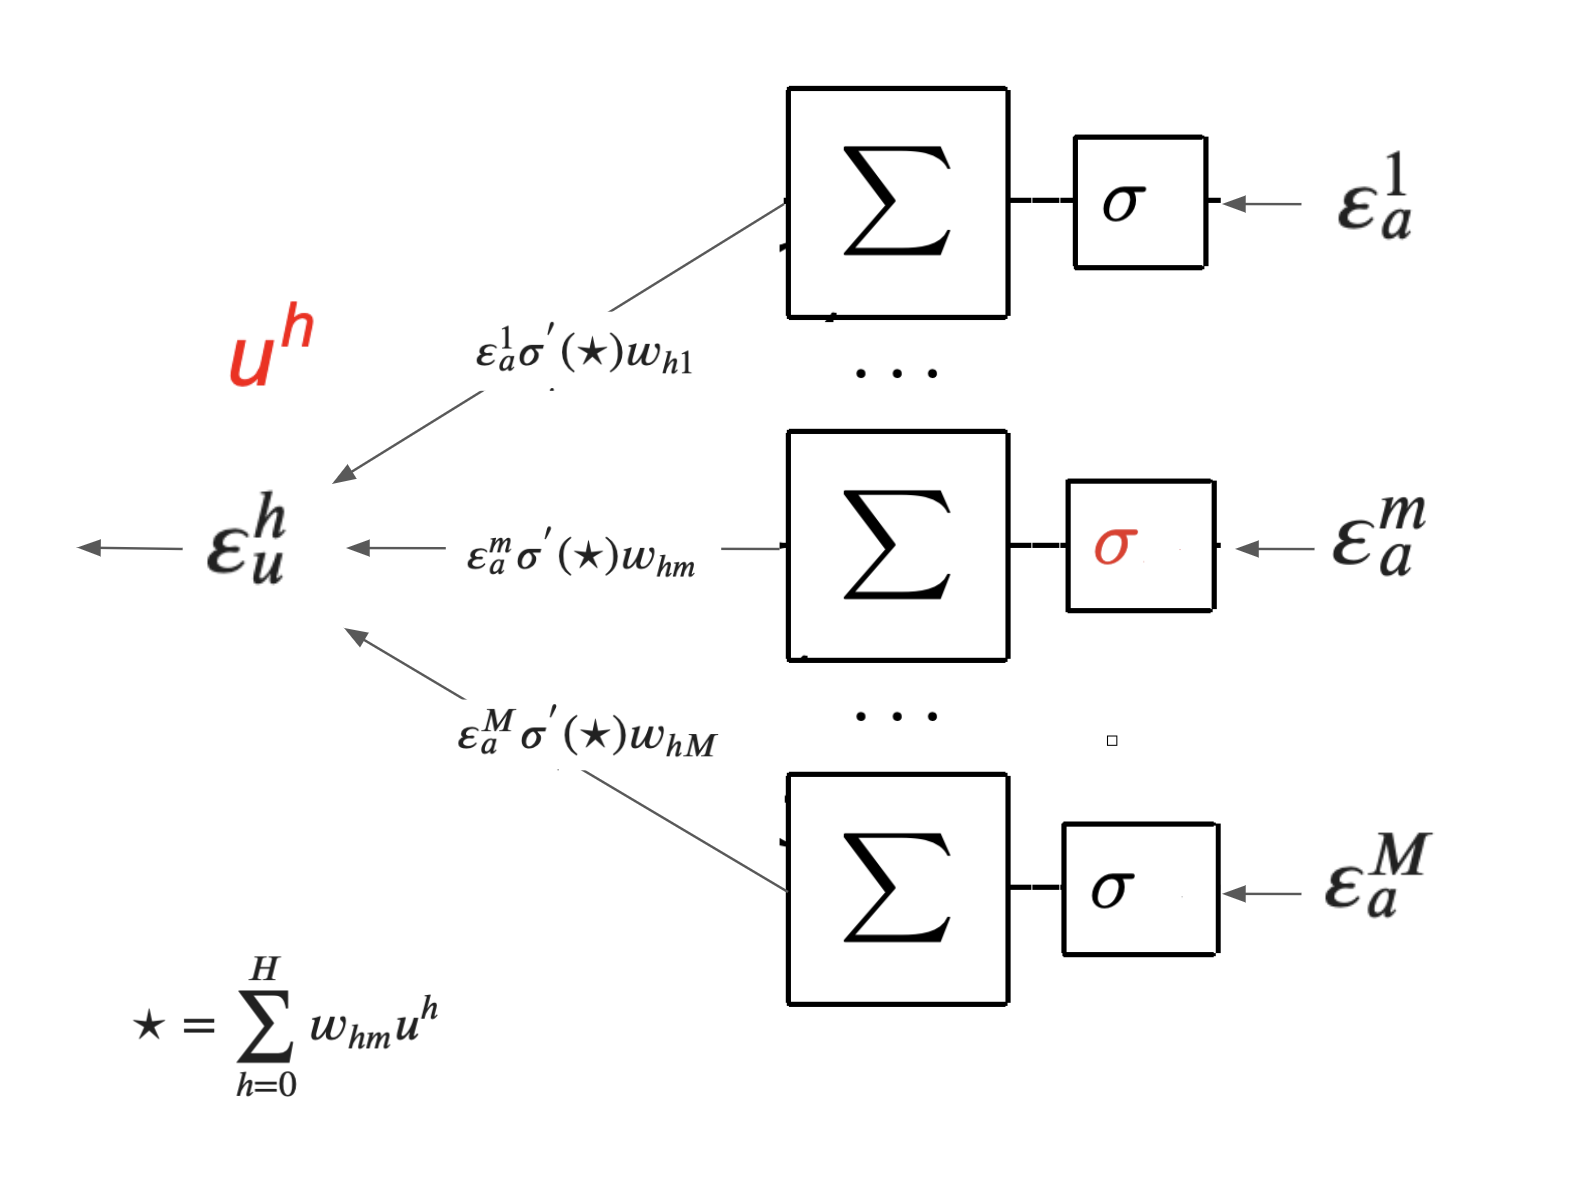

In [18]:
Image('images/nn_back.png', width=400)

Мы посчитали ошибки для скрытого слоя. Очевидно что точно таким же образом мы можем посчитать ошибки на след. слое просто заменив в формуле $\varepsilon_a^{m}$ на $\varepsilon_u^{h}$, так как они все идетничны.

$$\frac{\partial\mathcal{L}}{\partial x^{j}} = \sum_{h=0}^{H}\frac{\partial\mathcal{L}}{\partial u^{h}}\frac{\partial u^{h}}{\partial x^{j}} = \sum_{h=0}^{H} \varepsilon_u^h \sigma^{'}(\star)w_{jh} = \varepsilon_{x}^{j}$$ где $\star = \sum_{j=0}^{n}w_{jh}x^j$ (эту штуку можно закешировать на этапе forward)

### Производные весов

Теперь осталось посчитать производные для весов

Для последнего слоя.
$$\frac{\partial\mathcal{L}}{\partial w_{hm}} = \frac{\partial\mathcal{L}}{\partial a^{m}}\frac{\partial a^{m}}{\partial w_{hm}} = \varepsilon_a^{m}\sigma^{'}(\star)u^{h}$$
где $\star = \sum_{h=0}^{H}w_{hm}u^h$


Для скрытого аналогично
$$\frac{\partial\mathcal{L}}{\partial w_{jh}} = \frac{\partial\mathcal{L}}{\partial u^{h}}\frac{\partial u^{h}}{\partial w_{jh}} = \varepsilon_u^{h}\sigma^{'}(\star)x^{j}$$
где $\star = \sum_{j=0}^{n}w_{jh}x^j$

Отлично, теперь мы можем совершить градиентный спуск для каждого веса.

$w_{hm}^{new} = w_{hm}^{old} - \eta \frac{\partial \mathcal{L}}{\partial w_{hm}}$

### Полный алгоритм BackPropagation

* Инициализировать веса W для каждого слоя сети (например рандомом от 0 до 1)
* повторить для каждого объекта из выборки X сколько-то итераций
    1. прямой ход посчитать вектора выходов $u$ и $a$ из слоев
    2. $u^h = \sigma\Big(\sum_{j=0}^{n}w_{jh}x^j\Big)$ 
    3. $ a^{m} = \sigma\Big(\sum_{h=0}^{H}w_{hm}u^h(x)\Big)$
    4. Обратный ход: посчитать векторы градиентов (ошибки) $\varepsilon_a = \frac{\partial \mathcal{L}}{\partial a}$, $\varepsilon_u = \frac{\partial \mathcal{L}}{\partial u}$
    6. $$\frac{\partial\mathcal{L}}{\partial u^{h}} = \sum_{m=0}^{M} \varepsilon_a^m \sigma^{'}(\star)w_{hm} = \varepsilon_{u}^{h}$$ 
    5. Посчитать матрицы градиентов весов $$\frac{\partial\mathcal{L}}{\partial w_{hm}} = \frac{\partial\mathcal{L}}{\partial a^{m}}\frac{\partial a^{m}}{\partial w_{hm}} = \varepsilon_a^{m}\sigma^{'}(\star)u^{h}$$
    6. Обновить веса через градиентный спуск: $w_{hm}^{new} = w_{hm}^{old} - \eta \frac{\partial \mathcal{L}}{\partial w_{hm}}$



-----

## Приведем теперь алгоритм в вид получше)

#### 1. Разделение сумматора и активации
Шаг сумматора и активации, обычно идут отдельно. Поэтому ошибки считаются отдельно после линейного слоя и после сигмоиды.


* $\varepsilon_a^{m} = a^{m} - y^{m}$

* $\varepsilon_{\star_u}^{m} = \frac{\partial \mathcal{L}}{\partial a^{m}}\frac{\partial a^{m}}{\partial \star_u} = \varepsilon_a^{m}\sigma^{'}(\star_u)$ где $\star_u = \sum_{h=0}^{H}w_{hm}u^h$

Аналогично

* $\varepsilon_u^{h} = \sum_{m=0}^{M}\varepsilon_{\star_u}^{m}  w_{hm}$

* $\varepsilon_{\star_x}^{m} = \varepsilon_u^{h}\sigma^{'}(\star_x)$, где $\star_x = \sum_{j=0}^{n}w_{jh}x^j$

И.т.д.

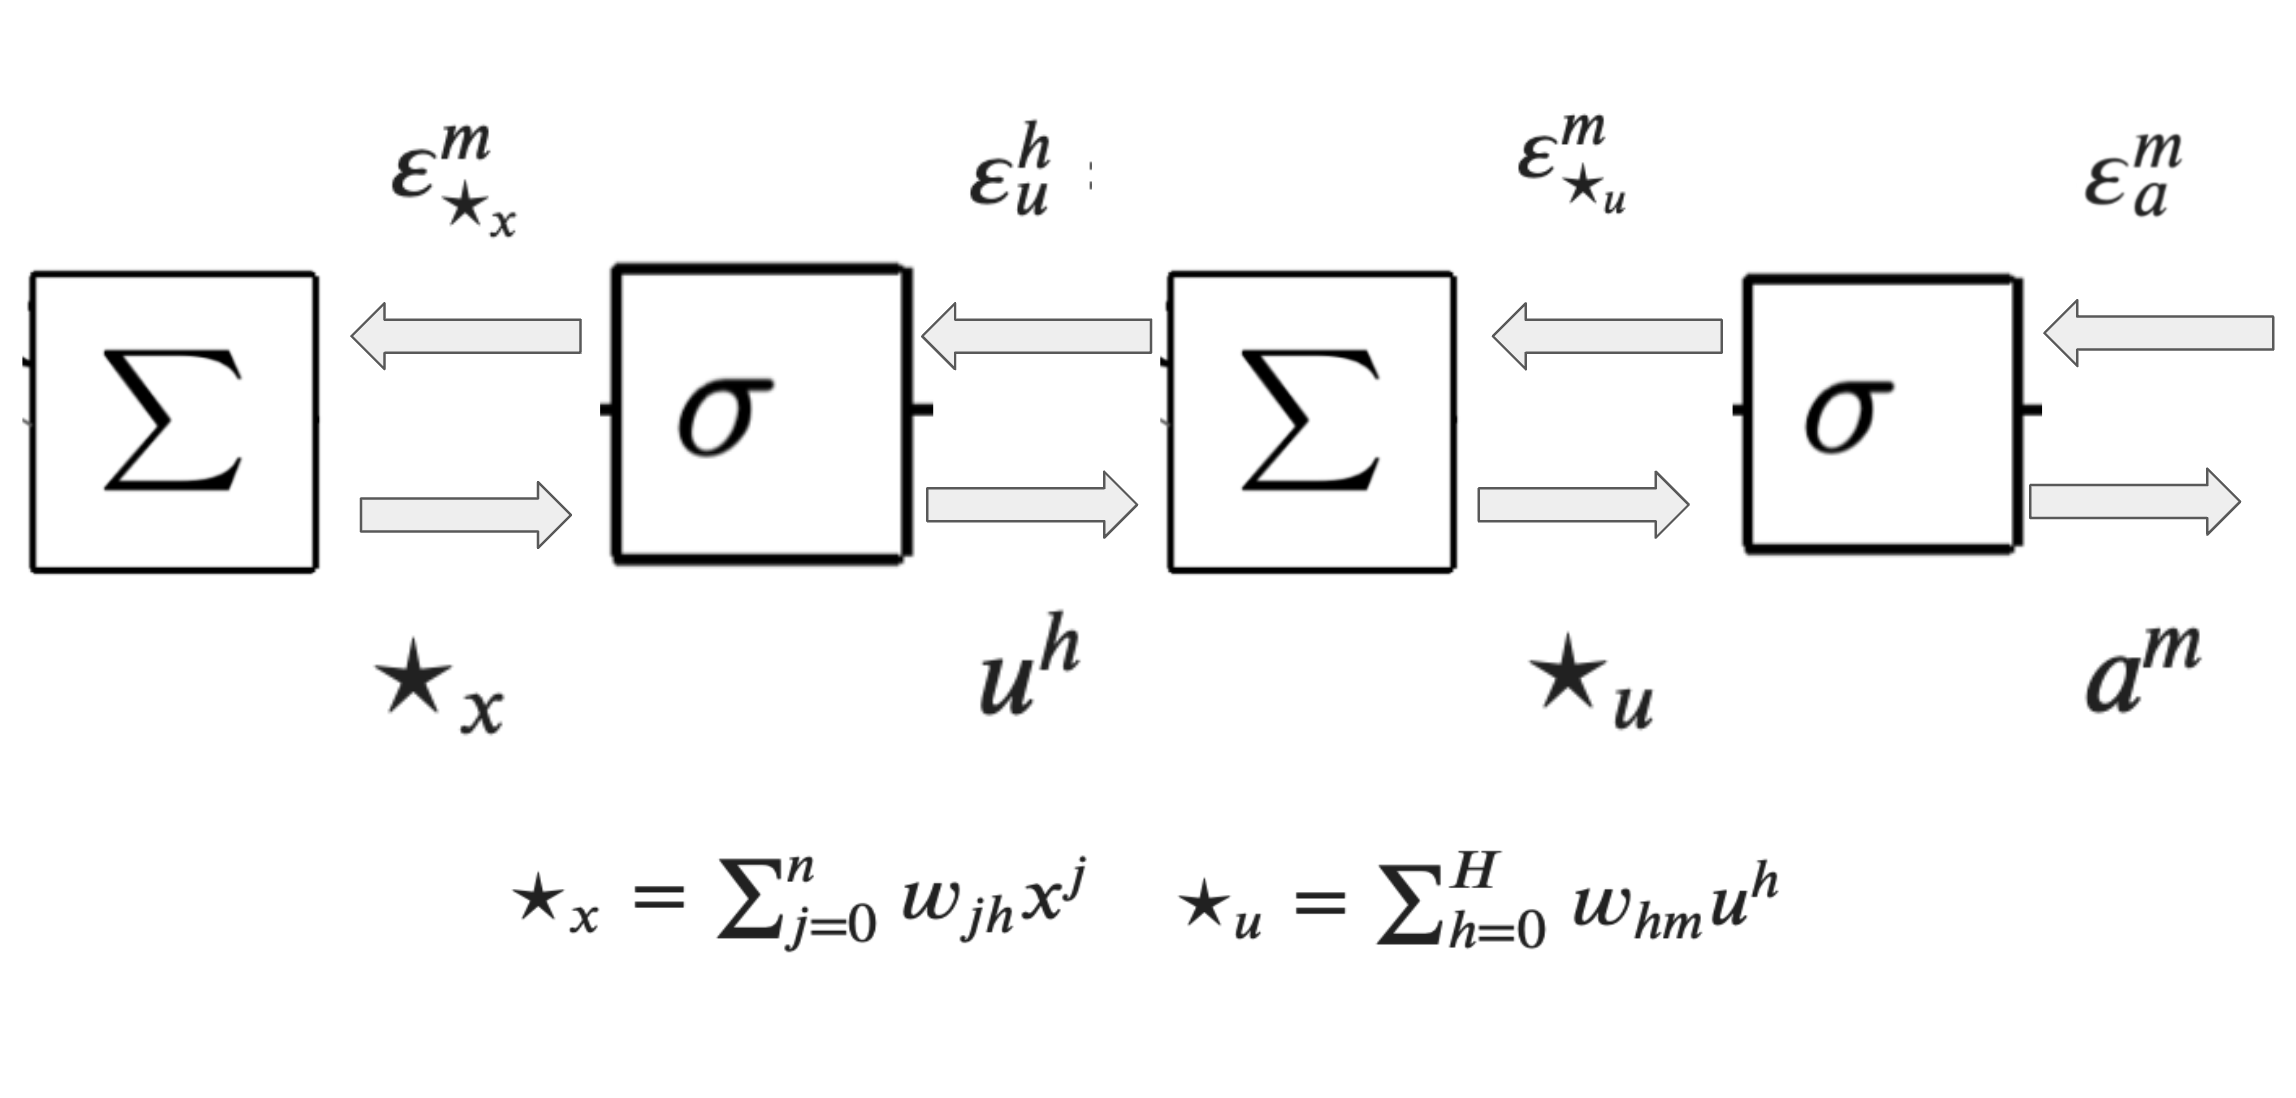

In [17]:
Image('images/nn_delim.png', width=400)

Шаг сумматора тогда будет выглядеть так

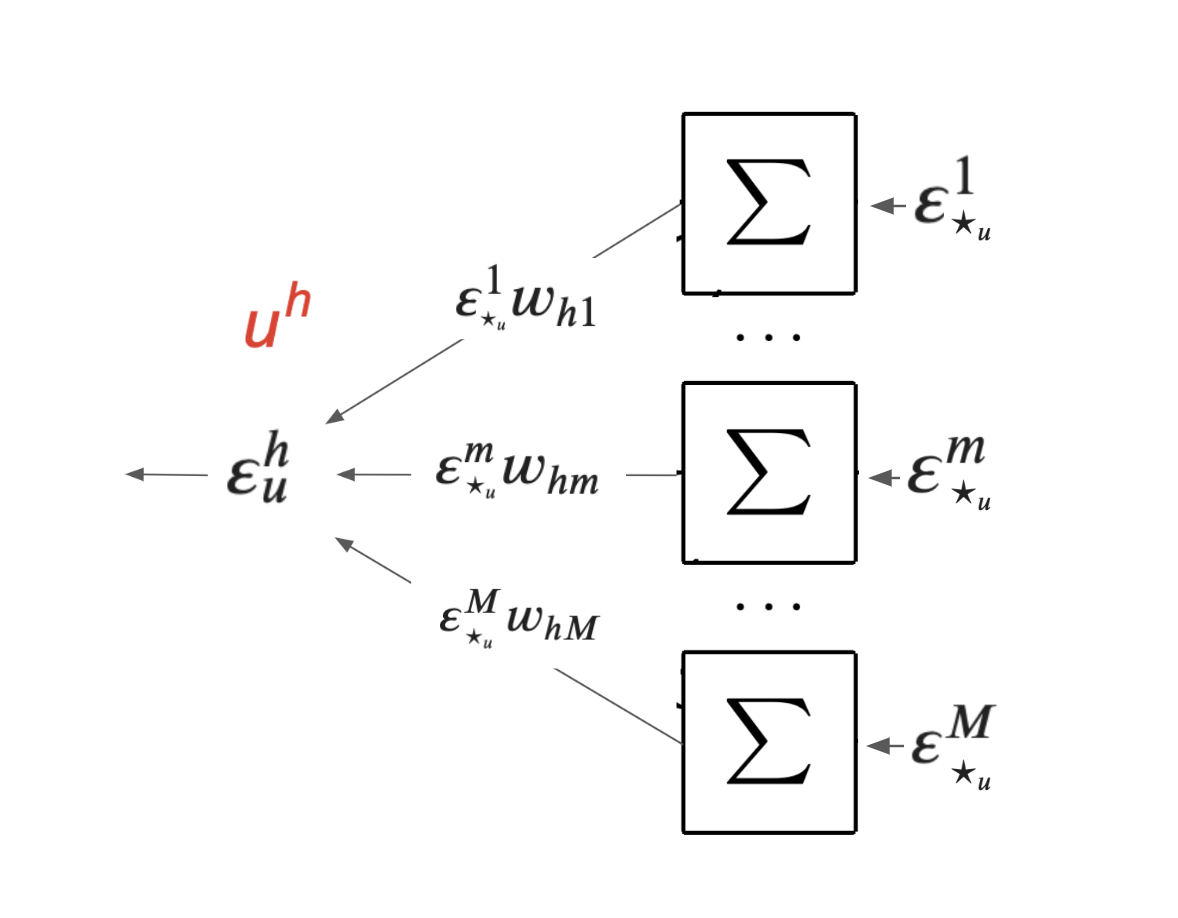

In [16]:
Image('images/nn_only_lin.png', width=400)

### 2. Приведение к матричному виду

В таком случае нам уже удобно работать с **матричными** вычислениями. Все вектора - столбцы

Вектора:  $a$, $u$, $\star_u$, $\star_x$

Вектора ошибок: $\varepsilon_a$, $\varepsilon_u$, $\varepsilon_{\star_u}$, $\varepsilon_{\star_x}$

Матрицы весов: $W_{x}$ - первый слой, $W_{u}$ - второй слой

Forward
$$\star_u = W_{u}u$$

Backward
$$\frac{\partial \mathcal{L}}{\partial W_u} = \frac{\partial \mathcal{L}}{\partial \star_u} \frac{\partial \star_u}{\partial W_u} = \varepsilon_{\star_u} u^T$$

### 3. Использование сразу несколько объектов из выборки

Выше для простоты мы рассматривали лишь один объект из выборки и Лосс функцию, вместо функционала ошибки. Давайте теперь сделаем все аккуратно и честно.



$$\mathcal{L} = \frac{1}{2N}\sum_{i=1}^{N}\sum_{m=1}^{M}(a^{m} - y^{m})^2$$

Каждый объект параллельно мы проводим по нейронной сети и высчитываем вектора $a(x_i)$, $u(x_i)$ для каждого $i$. 
По сути у нас на каждом слое будет теперь не вектор, а матрица. 

**Однако веса сети не параллелятся, они одни и те же для каждого объекта $x_i$**

Тогда пересчет весов будет происходить следующим образом

$$\frac{\partial \mathcal{L}}{\partial W_u} = \frac{1}{N}\sum_{i=1}^{N}\frac{\partial \mathcal{L}^i}{\partial a^{i}}\frac{\partial a^{i}}{\partial \star_u^{i}}\frac{\partial \star_u^{i}}{\partial W_u} =  \frac{1}{N}\sum_{i=1}^{N}\varepsilon_a^{i}\sigma(\star_u^{i})u^i$$

где $i$ - вектор образовавшийся от объекта $x_i$




### 4. Алгоритм обратного распространения ошибки (норм версия)

1. Инициализировать веса W для каждого слоя сети (например рандомом от 0 до 1)
2. повторить для выборки X сколько-то итераций
    1. прямой ход посчитать вектора выходов $u$ и $a$ из слоев
    2. $u = \sigma\Big(W^{u} x\Big)$, $W^{u}$ - матрица первого слоя
    3. $a = \sigma\Big(W^{a} u\Big)$, $W^{a}$ - матрица второго слоя
    4. Обратный ход: посчитать векторы градиентов (ошибки) $\varepsilon_a = \frac{\partial \mathcal{L}}{\partial a}$, $\varepsilon_u = \frac{\partial \mathcal{L}}{\partial u}$
    5. Посчитать матрицы градиентов весов $\frac{\partial \mathcal{L}}{\partial W_{u}}$, $\frac{\partial \mathcal{L}}{\partial W_{x}}$
    6. Обновить веса через градиентный спуск:
        $W^{new} = W^{old} + \eta \frac{\partial \mathcal{L}}{\partial W^{a}}$


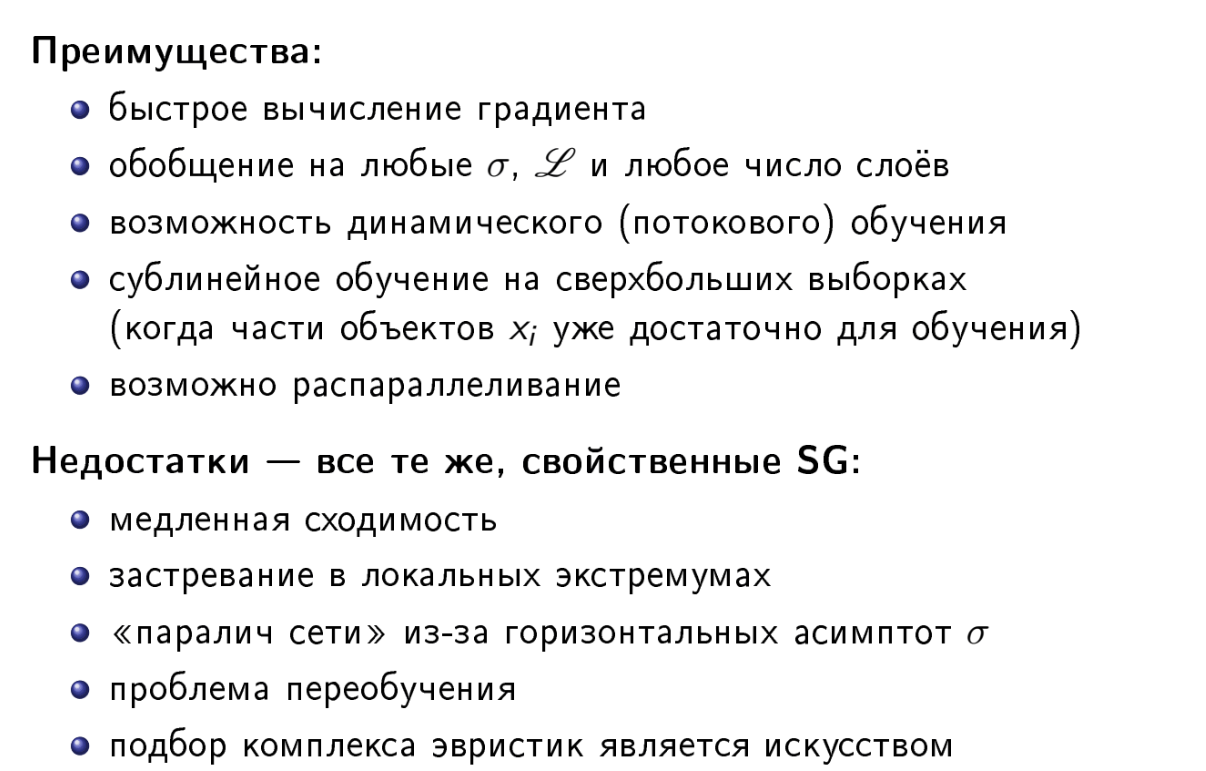

In [19]:
Image('images/plusmin.png', width=600)

In [13]:
# Подготовили данные 
x = torch.linspace(-math.pi, math.pi, 2000)
y = torch.pow(x,2)
p = torch.tensor([1, 2, 3])
xx = x.unsqueeze(-1).pow(p)

# Define model
model = torch.nn.Sequential(
    torch.nn.Linear(3, 3),
    torch.nn.ReLU(),
    torch.nn.Linear(3, 3),
    torch.nn.ReLU(),
    torch.nn.Linear(3, 1),
    torch.nn.Flatten(0, 1)
)

loss_fn = torch.nn.MSELoss()

learning_rate = 1e-2
for it in range(2000):
    # Forward pass: все до последней ноды
    y_pred = model(xx) 

    # Compute loss: финальная нода с лоссом
    loss = loss_fn(y_pred, y)
    if it % 100 == 99:
        print(it, loss.item())

    # Обнулили градиенты с прошлой итерации
    model.zero_grad()    
        
    # Backward pass: просчитали градиенты назад
    loss.backward()

    # Update the weights using gradient descent. 
    with torch.no_grad():
        for param in model.parameters():
            param -= learning_rate * param.grad

            

# просто рисовалка   
# а вот тут формулы не существует :))
plt.plot(x, np.pow(x,2), label='sin')
plt.plot(x, model(xx).detach().numpy(), label='polynom')
plt.xlabel('x')
plt.ylabel('y')

plt.legend()
plt.grid()

99 8.946982383728027
199 8.680681228637695
299 8.675997734069824
399 8.675915718078613
499 8.675914764404297
599 8.675914764404297
699 8.675914764404297
799 8.675914764404297
899 8.675914764404297
999 8.675914764404297
1099 8.675914764404297
1199 8.675914764404297
1299 8.675914764404297
1399 8.675914764404297
1499 8.675914764404297
1599 8.675914764404297
1699 8.675914764404297
1799 8.675914764404297
1899 8.675914764404297
1999 8.675914764404297


AttributeError: module 'numpy' has no attribute 'pow'

# Полезные ссылки
* [Видео по алгоритму](https://www.youtube.com/watch?v=tIeHLnjs5U8)
* [Методичка Воронцова по нейронкам](http://ultra27.ccas.ru/voron/download/NeuralNets.pdf)
* [Видос Воронцова, откуда взяты слайды](https://www.youtube.com/watch?v=zbdgUZAzfQg&list=PLJOzdkh8T5krxc4HsHbB8g8f0hu7973fK&index=13)
* [Анимации градиентных спусков](http://www.denizyuret.com/2015/03/alec-radfords-animations-for.html)
* [Про softmax](https://konstantinklepikov.github.io/2019/06/27/cs2131n-sofrmax.html)
* [Softmax better than Normalization](https://stackoverflow.com/questions/17187507/why-use-softmax-as-opposed-to-standard-normalization)
